# eXtreme Gradient Boosting (XGB) Model, Trained Globally

In [1]:
# Standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle

# Machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model

# Python file with supporting functions
import model_utils

2023-01-11 13:23:26.933511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
global_model_path = '/home/julias/MLEE-final-project/models/saved_models/global_models'

### To Set and Track Seeds for Reproducibility (Referencing Group Standard):

In [ ]:
ens = 'CESM'
member = '009'
reference_output_dir = '/home/julias/MLEE-final-project/pickle_files'

path_seeds = f'{reference_output_dir}/random_seeds.npy'
random_seeds = np.load(path_seeds)  

path_loc = f'{reference_output_dir}/cesm_seed_loc_dict.pickle'
with open(path_loc,'rb') as handle:
    seed_loc_dict = pickle.load(handle)
seed_loc = seed_loc_dict[ens][member]

# for next project, where train and test datasets use all CESM members
#path_cesm = f"{reference_output_dir}/cesm_members_dict.pickle"
#with open(path_cesm,'rb') as handle:
#    cesm_mems_dict = pickle.load(handle)

In [ ]:
# random_seeds

In [ ]:
# seed_loc_dict # using CESM 009, so seed_loc should be 32

In [ ]:
# seed_loc #confirmed 32

# Load Split Datasets and Create Versions for Experimentation

## Load Split Datasets

In [17]:
X_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X.nc').to_dataframe().dropna()
y_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y.nc').to_dataframe().dropna() 
X_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_train.nc').to_dataframe().dropna() 
y_train_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_train.nc').to_dataframe().dropna()
X_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_test.nc').to_dataframe().dropna() 
y_test_df = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_test.nc').to_dataframe().dropna() 

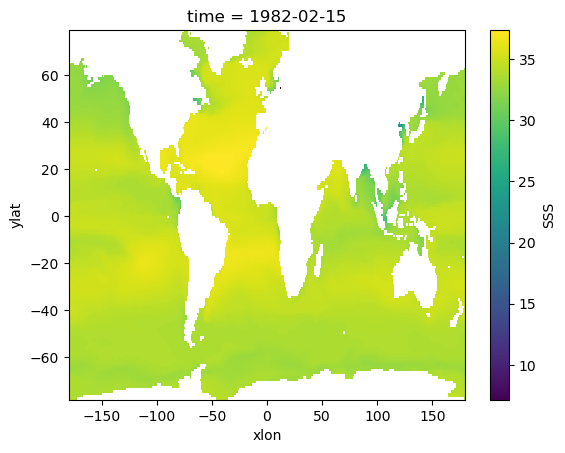

In [21]:
X_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').SSS[0,:,:].plot()

## Create Original Dataframes

In [ ]:
# X_train_df

In [ ]:
# X_train_ds.SSS[0,:,:].plot()

## Create Normalized Dataframes

*Note: Done here, as opposed to in test/train split, so that I can save the original train/test datasets and later determine whether normalization led to improvement. (My group has not historically normalized data before training.)*

**Uses Third (Updated) Method of Normalization**

- Surprised at lack of improvement from normalization (as done previously using the second method)  
- Problem may be coming from the use of a global mean/std, as opposed to one specific to each latitude and longitude point. 
- Replaced normalized numpy arrays and dataframes previously run and saved (all moved to archive folder) with updated ones for each coordinate point (names normdfupdated and normnumpyupdated)

Change data import to dataset first, then dataframe

In [ ]:
#X_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
#y_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
#X_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
#y_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
#X_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/X_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
#y_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/split_datasets/y_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')

In [18]:
#X_df = X_ds.to_dataframe().dropna()
#y_df = y_ds.to_dataframe().dropna()
#X_train_df = X_train_ds.to_dataframe().dropna()
#y_train_df = y_train_ds.to_dataframe().dropna()
#X_test_df = X_test_ds.to_dataframe().dropna()
#y_test_df = y_test_ds.to_dataframe().dropna()

In [14]:
#X_ds_norm = model_utils.normalize_X_dataset(X_ds)
#X_train_ds_norm = model_utils.normalize_X_dataset(X_train_ds)
#X_test_ds_norm = model_utils.normalize_X_dataset(X_test_ds)

#y_ds_norm = model_utils.normalize_y_dataset(y_ds)
#y_train_ds_norm = model_utils.normalize_y_dataset(y_train_ds)
#y_test_ds_norm = model_utils.normalize_y_dataset(y_test_ds)

In [15]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(12,10))

#X_ds_norm.SSS[0].plot(ax=ax1)
#X_ds_norm.XCO2[0].plot(ax=ax2)
#X_ds_norm.MLD[0].plot(ax=ax3)
#X_ds_norm.Chl[0].plot(ax=ax4)

In [ ]:
#X_df_norm = X_ds_norm.to_dataframe().dropna()
#y_df_norm = y_ds_norm.to_dataframe().dropna()
#X_train_df_norm = X_train_ds_norm.to_dataframe().dropna()
#y_train_df_norm = y_train_ds_norm.to_dataframe().dropna()
#X_test_df_norm = X_test_ds_norm.to_dataframe().dropna()
#y_test_df_norm = y_test_ds_norm.to_dataframe().dropna()

# Select Approach & Parameters

## Approach

Based on preliminary experimentation in the non-global XGB notebook (XGB.ipynb) will only train the global dataset on the identified ideal approach. Thus, will train on dataframes (as opposed to numpy arrays) and original data.

## Parameters

### Reference Best Parameters from Previous Group Work

Published in Bennington 2022, trained XGB to learn pCO2 residual (pC02 change with direct temperature effects removed)

In [ ]:
path_bp='/data/artemis/workspace/vbennington/full_sst/pCO2_DIC/models/performance_metrics/xg/xg_best_params_dict.pickle'
with open(path_bp,'rb') as handle:
    best_params = pickle.load(handle)
print(best_params)

Use previous CESM best parameters as a starting point:
- max_depth = 6
- n_estimators = 4000

### Investigate Ideal Parameters for Selected Approach

- Test with three different n_estimators and 3 different depths
- Advice from group post-doc: For XGB, too many depth layers may lead to overfitting (usually 8 or less layers for XGB)
- We want the combo of xg_param_grid that gives the lowest RMSE

- Was not able to use GridSearchCV (allowed to run for hours but kernel crashed on multiple attempts. 
- Will re-attempt on a future project using NCAR supercomputer account once have access.

In [ ]:
# best_params = {}
# model = xgb.XGBRegressor(verbosity=0) 
# xg_param_grid = {'n_estimators':[3000, 4000, 5000],
#                  'max_depth':[5, 6, 7]}
# grid = GridSearchCV(model, xg_param_grid, scoring='neg_mean_squared_error') #, cv=K_folds, return_train_score=False, refit=False

In [ ]:
# grid.fit(X_train_df_norm, y_train_df_norm)

In [ ]:
# best_params[ens] = grid.best_params_
# print(best_params)

# Preliminary XGB Models

***Goal: Compare auto-XGB with lowest end and highest end of group XGB parameter matrix***

## Baseline Model Test

Alternations should at least improve on the baseline set by the auto-generated XGB algorithm

In [ ]:
model_baseline = xgb.XGBRegressor(verbosity=0) 

In [ ]:
model_baseline.fit(X_train_df, y_train_df)

Learning rate looks high, may need to manually set

In [ ]:
joblib.dump(model_baseline, os.path.join(global_model_path,'XGB_prelim_baseline.h5')) 

In [38]:
baseline_model = joblib.load(os.path.join(global_model_path,'XGB_prelim_baseline.h5'))

In [46]:
train_score_baseline = baseline_model.score(X_train_df, y_train_df)
train_score_baseline

0.9309826205041454

In [47]:
test_score_baseline = baseline_model.score(X_test_df, y_test_df) 
test_score_baseline

0.9283990528928113

In [48]:
y_pred_baseline = baseline_model.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_baseline)
print("MSE: %.2f" % mse)

MSE: 99.97


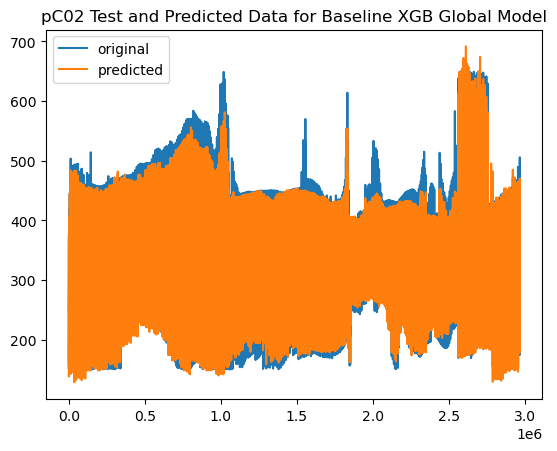

In [50]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_baseline, label="predicted")
plt.title("pC02 Test and Predicted Data for Baseline XGB Global Model")
plt.legend()
plt.show()

## Lowest Combination of XGB Parameter Matrix

In [ ]:
model_low = XGBRegressor(n_estimators=3000, max_depth=5) #if want to set learning rate, eta: "often set to small values such as 0.3, 0.1, 0.01, or smaller"
model_low.fit(X_train_df, y_train_df) 

In [ ]:
joblib.dump(model_low, os.path.join(global_model_path,'XGB_prelim_lowest_param.h5')) 

In [26]:
model_low = joblib.load(os.path.join(global_model_path,'XGB_prelim_lowest_param.h5'))

In [27]:
train_score_low = model_low.score(X_train_df, y_train_df) 
train_score_low

0.9749804874129351

In [28]:
test_score_low = model_low.score(X_test_df, y_test_df) 
test_score_low

0.9659307851315589

In [30]:
y_pred_low = model_low.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_low)
print("MSE: %.2f" % mse)

MSE: 47.57


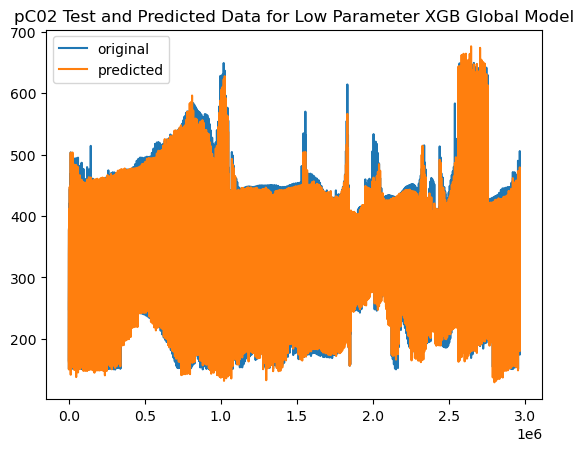

In [51]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_low, label="predicted")
plt.title("pC02 Test and Predicted Data for Low Parameter XGB Global Model")
plt.legend()
plt.show()

## Highest Combination of XGB Parameter Matrix

In [32]:
model_high = XGBRegressor(n_estimators=5000, max_depth=8)
model_high.fit(X_train_df, y_train_df) 


KeyboardInterrupt



In [ ]:
joblib.dump(model_high, os.path.join(global_model_path,'XGB_prelim_highest_param.h5')) 

In [33]:
model_high = joblib.load(os.path.join(global_model_path,'XGB_prelim_highest_param.h5'))

In [34]:
train_score_high = model_high.score(X_train_df, y_train_df) 
train_score_high

0.9946347122998299

In [35]:
test_score_high = model_high.score(X_test_df, y_test_df) 
test_score_high

0.9704181105395544

In [36]:
y_pred_high = model_high.predict(X_test_df)
mse = mean_squared_error(y_test_df, y_pred_high)
print("MSE: %.2f" % mse)

MSE: 41.30


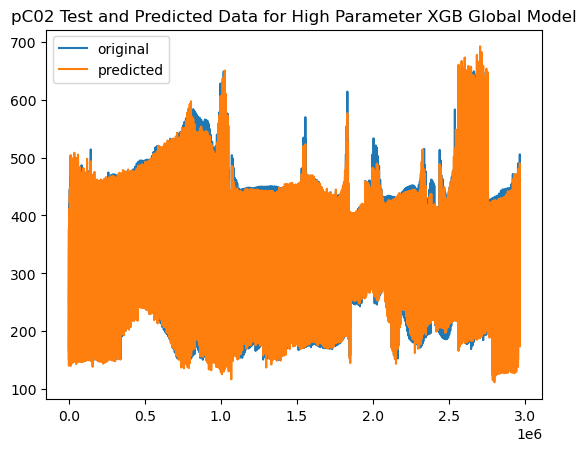

In [52]:
x_ax = range(len(y_test_df))
plt.plot(x_ax, y_test_df, label="original")
plt.plot(x_ax, y_pred_high, label="predicted")
plt.title("pC02 Test and Predicted Data for High Parameter XGB Global Model")
plt.legend()
plt.show()

In [ ]:
# model_high.save_model(os.path.join(global_model_path,'XGB_prelim_highest_param.h5'))

In [ ]:
X_ds = X_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
X_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_train_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_train.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
X_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/X_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')
y_test_ds = xr.open_dataset('/home/julias/MLEE-final-project/proc_data/global_split_datasets/y_test.nc').sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')

# Create Analysis Plots

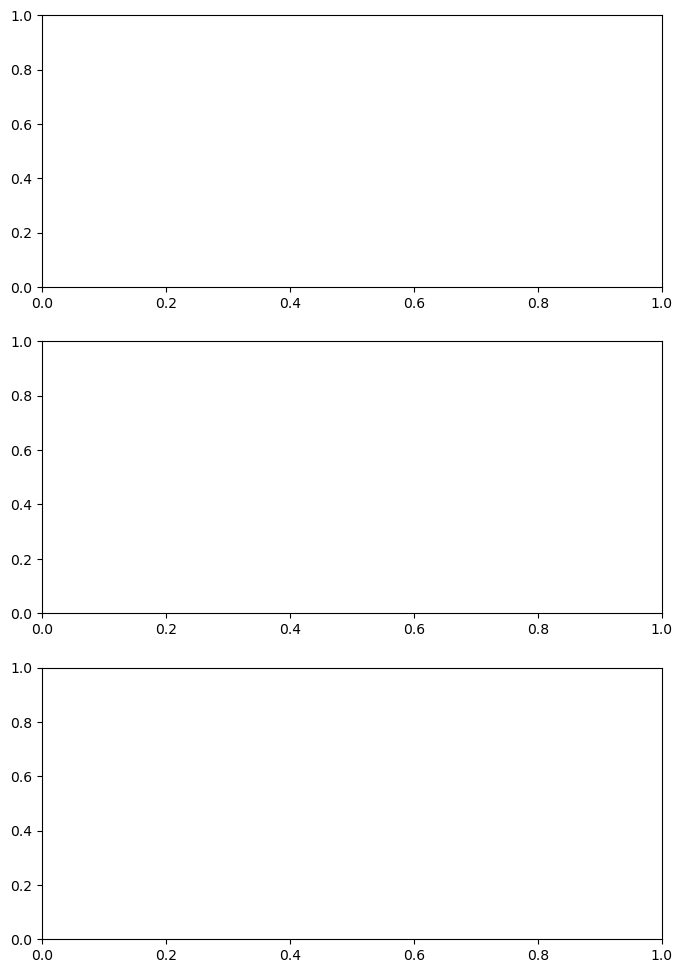

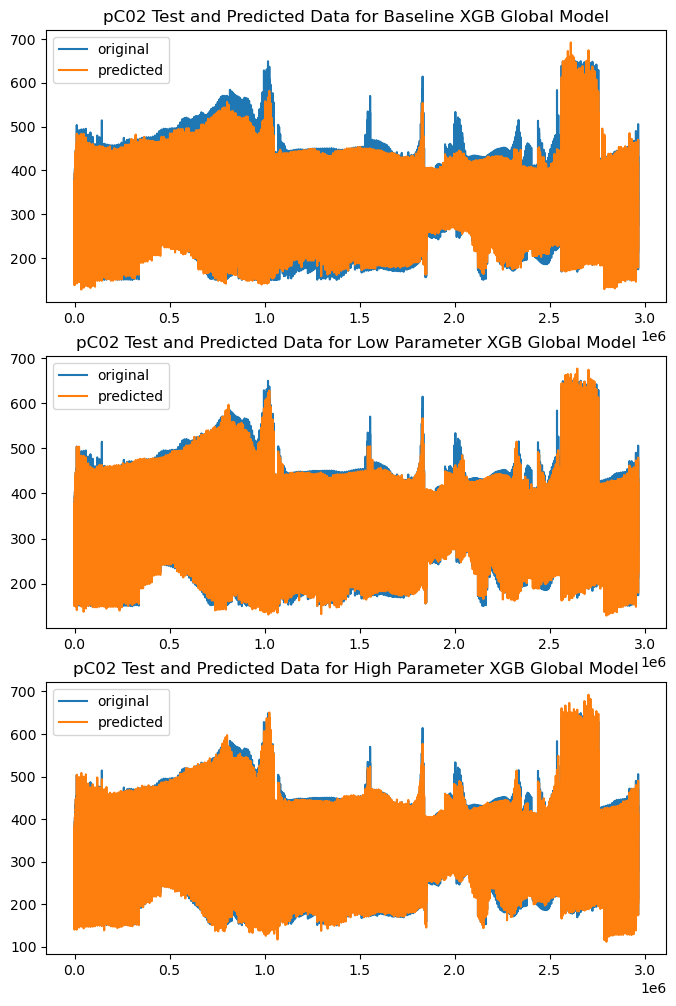

In [65]:
fig, ax = plt.subplots(nrows=3, figsize=(8,12)) 

r1 = range(len(y_test_df))
ax[0].plot(r1, y_test_df, label="original")
ax[0].plot(r1, y_pred_baseline, label="predicted")
ax[0].set_title("pC02 Test and Predicted Data for Baseline XGB Global Model")
ax[0].legend()

r2 = range(len(y_test_df))
ax[1].plot(r2, y_test_df, label="original")
ax[1].plot(r2, y_pred_low, label="predicted")
ax[1].set_title("pC02 Test and Predicted Data for Low Parameter XGB Global Model")
ax[1].legend()

r3 = range(len(y_test_df))
ax[2].plot(r3, y_test_df, label="original")
ax[2].plot(r3, y_pred_high, label="predicted")
ax[2].set_title("pC02 Test and Predicted Data for High Parameter XGB Global Model")
ax[2].legend()

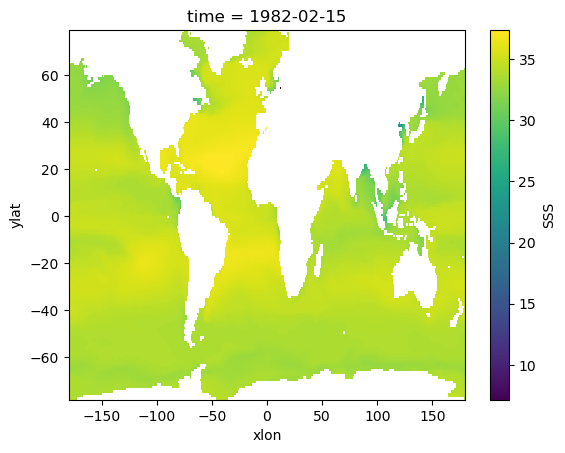

In [29]:
X_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon').SSS[0,:,:].plot()

In [66]:
y_test_df['baseline_pred'] = y_pred_baseline
y_test_df['low_pred'] = y_pred_low
y_test_df['high_pred'] = y_pred_high

y_comparison = y_test_df.to_xarray().sortby(['time','xlon','ylat']).transpose('time','ylat','xlon')

Text(0.5, 1.0, 'pC02 Predicted Data in September 2016 \n for High Parameter XGB Global Model')

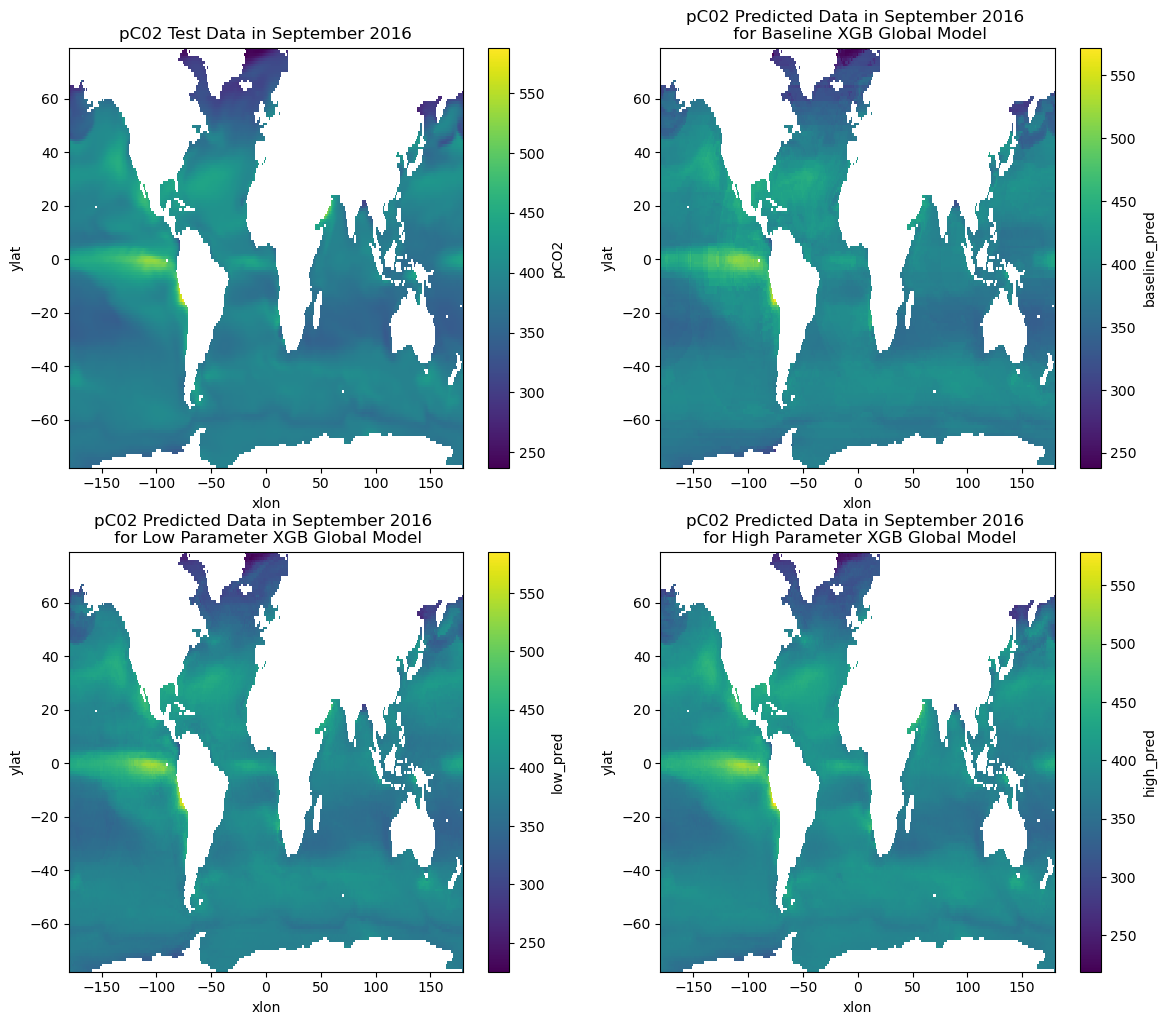

In [76]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, figsize=(14,12))

y_comparison.sel(time='2016-9-15').pCO2.plot(ax=ax1)
ax1.set_title('pC02 Test Data in September 2016')

y_comparison.sel(time='2016-9-15').baseline_pred.plot(ax=ax2)
ax2.set_title('pC02 Predicted Data in September 2016 \n for Baseline XGB Global Model')

y_comparison.sel(time='2016-9-15').low_pred.plot(ax=ax3)
ax3.set_title('pC02 Predicted Data in September 2016 \n for Low Parameter XGB Global Model')

y_comparison.sel(time='2016-9-15').high_pred.plot(ax=ax4)
ax4.set_title('pC02 Predicted Data in September 2016 \n for High Parameter XGB Global Model')

Text(0.5, 1.0, 'pC02 Bias in September 2016 for High Parameter XGB Global Model')

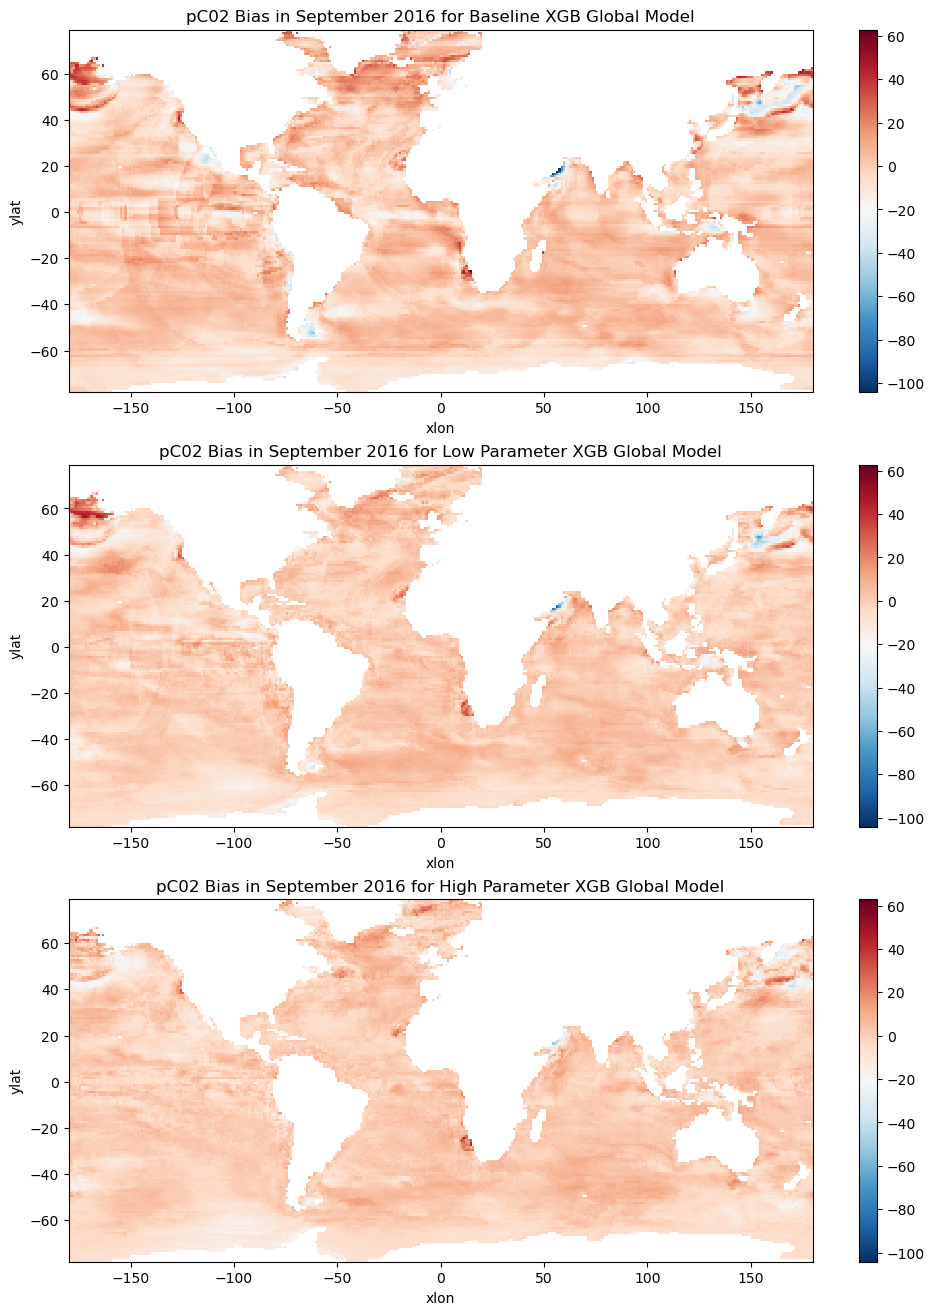

In [102]:
fig, ax = plt.subplots(nrows=3, figsize=(12,16))
selected_time = y_comparison.sel(time='2016-9-15')
test = selected_time.pCO2

unifymin = (selected_time.baseline_pred-selected_time.pCO2).min()
unifymax = (selected_time.baseline_pred-selected_time.pCO2).max()

(selected_time.baseline_pred-selected_time.pCO2).plot(ax=ax[0],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[0].set_title('pC02 Bias in September 2016 for Baseline XGB Global Model')

(selected_time.low_pred-selected_time.pCO2).plot(ax=ax[1],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[1].set_title('pC02 Bias in September 2016 for Low Parameter XGB Global Model')

(selected_time.high_pred-selected_time.pCO2).plot(ax=ax[2],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[2].set_title('pC02 Bias in September 2016 for High Parameter XGB Global Model')

Text(0.5, 1.0, 'Averaged pC02 Bias for High Parameter XGB Global Model')

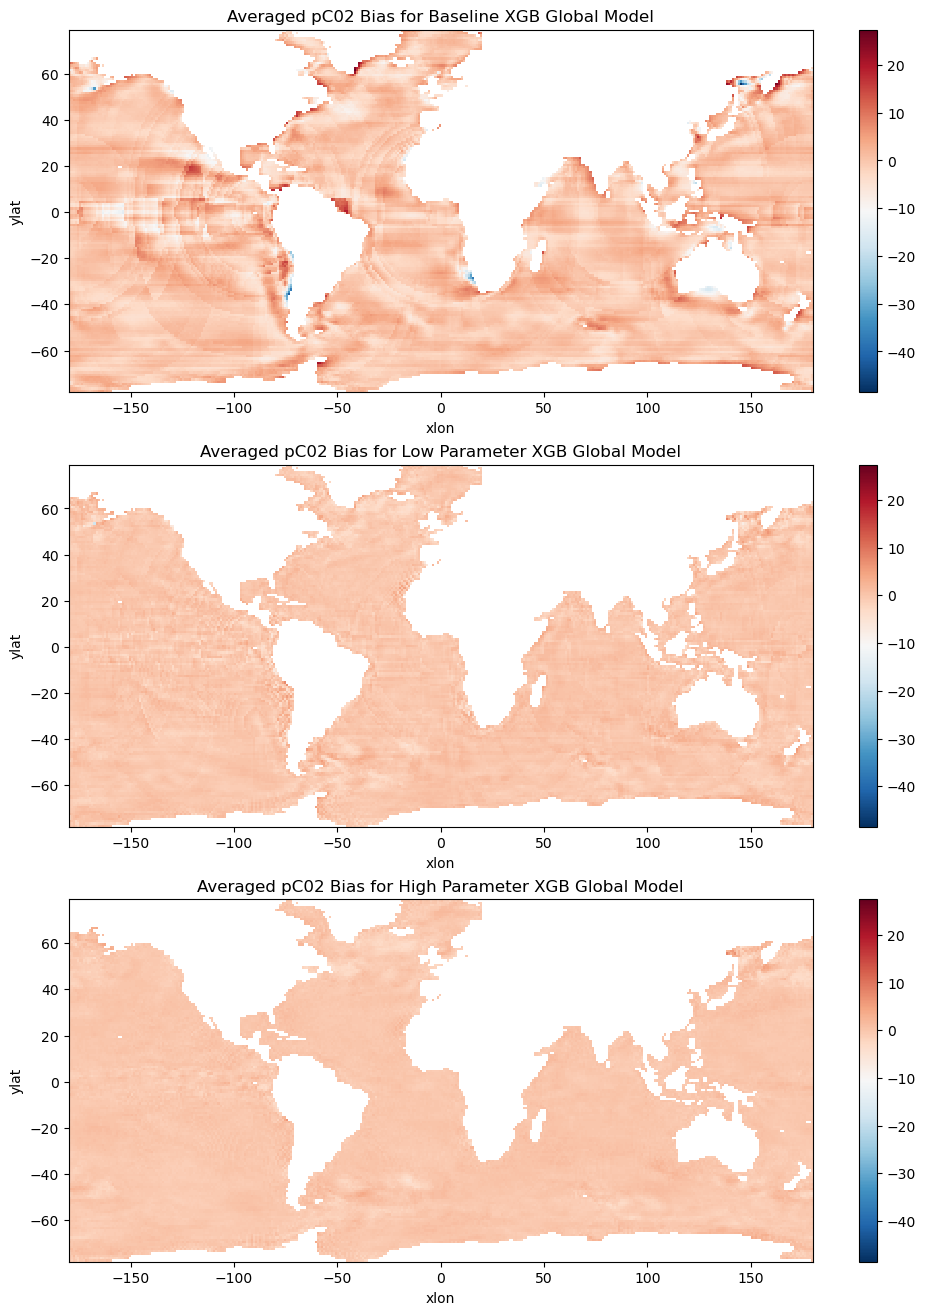

In [109]:
fig, ax = plt.subplots(nrows=3, figsize=(12,16))
avg = y_comparison.mean(dim='time')

unifymin = (avg.baseline_pred-avg.pCO2).min()
unifymax = (avg.baseline_pred-avg.pCO2).max()

(avg.baseline_pred-avg.pCO2).plot(ax=ax[0],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[0].set_title('Averaged pC02 Bias for Baseline XGB Global Model')

(avg.low_pred-avg.pCO2).plot(ax=ax[1],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[1].set_title('Averaged pC02 Bias for Low Parameter XGB Global Model')

(avg.high_pred-avg.pCO2).plot(ax=ax[2],vmin=unifymin,vmax=unifymax,cmap='RdBu_r')
ax[2].set_title('Averaged pC02 Bias for High Parameter XGB Global Model')